In [1]:
import numpy as np

In [24]:
import matplotlib.pyplot as plt

In [26]:
import pymc3 as pm

In [54]:
import scipy.stats as stats

In [23]:
%matplotlib inline

# Notes
* linear regression = family of simple statistical models learning abou mean + variance of some measure, using additive combination of other measure
* descriptive model corresponding to many process models
* likely to make mistakes if their structure read too literally
* this chapter: lin. regre. as bayesian procedure

## 4.1. Why normal distributions are normal
* sum of binomial events will be distributed Gaussian (football field example)

### 4.1.1. Normal by addition

In [68]:
# code 4.1
pos = [np.random.uniform(low=-1, high=1, size=16).sum() for _ in range(1000)]

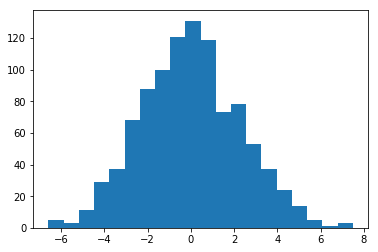

In [69]:
plt.hist(pos, bins=20);

* any process that adds together random values from the same distribution converges to normal
* conceptual help: each value is deviation from mean of drawing distribution. the more elements in sum of draws, the higher the chance that positive deviations cancel out with negative deviations, large ones with large ones etc, so the higher the chance we'll get something close to the mean out of the sum. there are more ways to realize the mean as a sum of draws than there are ways to realize extreme values
* works for nearly all underlying distrbutions

### 4.1.2. Normal by multiplication

In [71]:
# code 4.2
(1 + np.random.uniform(0, 0.1, 12)).prod()

1.8043404442938615

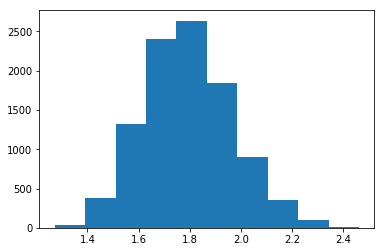

In [73]:
# code 4.3
growth = [(1 + np.random.uniform(0, 0.1, 12)).prod() for _ in range(10000)]
plt.hist(growth);

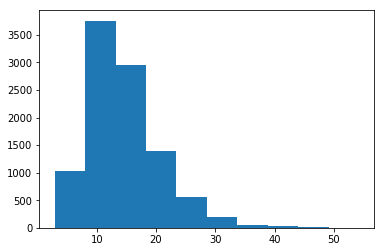

In [76]:
# code 4.4
big = [(1 + np.random.uniform(0, 0.5, 12)).prod() for _ in range(10000)]
plt.hist(big);

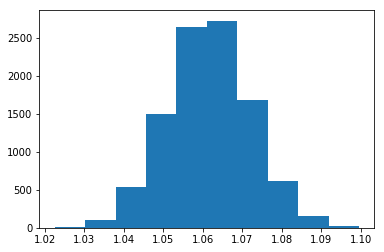

In [77]:
small = [(1 + np.random.uniform(0, 0.01, 12)).prod() for _ in range(10000)]
plt.hist(small);

* learned: multiplication of small numbers is roughly like addition, leads to Gaussian. the smaller the numbers, the better this works
* even more effects resulting in Gaussian

### 4.1.3. Normal by log-multiplication
* log of product of large deviations also leads to Gaussian, as log of product = sum of logs
* measurement scales are arbitrary, so 'log'-ing something is fair transformation

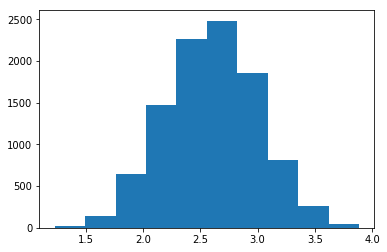

In [79]:
log_big = [np.log((1 + np.random.uniform(0, 0.5, 12)).prod()) for _ in range(10000)]
plt.hist(log_big);

### 4.1.4. Using Gaussian Distributions
* ontological justification for using Gaussian: world is full of it (approximately), b/c many processes add together random fluctuations
* consequence: cannot infer underlying process from model. can still build useful model
* other patterns also frequent and useful: exponential, gamma, Poisson, ...; all members of ***Exponential Family***
* epistemological justification: if we only want to make statements about mean and finite variance of some distribution then Gaussian is most general, does not need any other assumptions
* Gaussian is least informative and least surprising
* based on ***information theory*** and **maximum entropy***, subjects of later chapters
* using a model does not mean swearing an oath to it
* ***overthinking: gaussian distribution***:
* characteristic shape given by exp(\mu-y^2), rest of formula for standardization
* Gaussian is continuous function = ***probability density**
* typically denoted 'p' or 'f'
* denotes ***rate of change in cumulative probability** thus can be higher than 1, whole distribution still needs to integrate to 1
* discrete probability distributions like binomial: ***probability mass**
* typically denoted 'Pr'
* need to sum to 1, so no value can be higher than 1

## 4.2. A language for describing models
* model description consists of the following parts
* define outcome variable, thing we wish to predict or understand
* for each of these: define likelihood distribution defining plausibility of individual data points. for linear regression: always gaussian
* define predictor variables, which we want to use to learn something about outcome variables
* define relationship between parameters of outcome likelihood distribution to predictor variables. by doing this, we have to define and list all parameters of the model
* for all of these model parameters: choose priors = initial information state of the model before seeing any data
* fundamentally, models describe ways that values of variabes can arise given values of other variables

### 4.2.1. re-describing globe tossing model
* w~Binomial(n,p)
* w~Uniform(0,1)
* count of water is distributed binomially with sample size n and probability p 
* by writing like this assumption clear: Binomial assumes tosses to be indenpendent, so we know that model overall assumes that samples are independent of each other
* "variablename ~ distribution" is ***stochaistic*** mapping. no instance of variable known with certainty, some values are more plausible than others but many are possible
* ***overthinking: from model definition to bayes' theorem***

In [103]:
w = 6
n = 9
p_grid = np.linspace(start = 0, stop = 1, num = 100)

In [104]:
posterior = stats.binom.pmf(w, n, p_grid) * stats.uniform.pdf(p_grid)
posterior = posterior / posterior.sum()

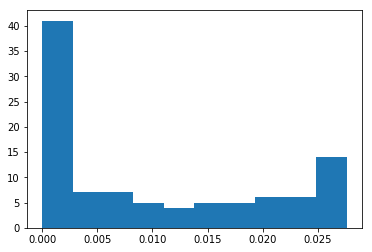

In [114]:
plt.hist(posterior);

***question***: this looks sort of weird? shouldn't 6 out of 9 lead to a much higher concentration around high values for p?

***question*** regarding outcome variable vers bayesian formulation. we define 'w' to be the outcome variable, so the thing we want to predict or understand. however, all the time before we were actually interested in inferring the value of 'p'. and in the bayesian formulation of the overthinking box, this also seems to be the case again. how do these two go together?

## 4.3. A Gaussian model of height
### 4.3.1. The data

In [2]:
import pandas as pd

In [120]:
# code 4.7
d = pd.read_csv('data/Howell1.csv', sep=';')

In [122]:
# code 4.8
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


In [124]:
# code 4.9
d.height.head()

0    151.765
1    139.700
2    136.525
3    156.845
4    145.415
Name: height, dtype: float64

In [126]:
# 4.10
d2 = d[d.age >= 18]

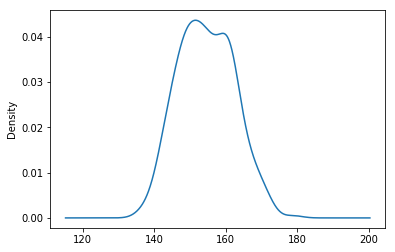

In [133]:
d2.height.plot(kind='density');

### 4.3.2. The model
* output plot (see above) suggest Gaussian as distribution for height var. but: 1) inspection can not always give good insight, could be mixture of multiple Gaussians etc and 2) Gaussian can be useful even if distr. looks different
* h_i = N(\mu, \sigma)
* note: index 'i' does not appear on righthand side, thus same distribution for all data points = i.i.d
* ***rethinking: iid***: independently and identically distributed. each data point has the same probability function. hardly ever true, e.g. heights within one family are probably correlated. however, not necessarily a problem. i.i.d. is epistemological assumption about uncertainty within the model, small-world. does not need to make claim about real world, i.e. does not imply ontological assumption (see E.T. Jaynes 'the mind fallacy', confusing epistemological with ontological claims). in ignorance of correlations: i.i.d. is most conservative, least informative, likely to be useful. {***Point I don't understand well***: de Finetti's Theorem about exchangeability and recognizing that multiple process models can lead to the same statistical model tell us that i.i.d. as an asssumption cannot be 'read too literally'}. Finally, some correlations just change order of data points, don't really affect shape of overall distributions, e.g. correllation between heights of sisters does not really impact Gaussian distribution of female height in general, so i.i.d. remains useful


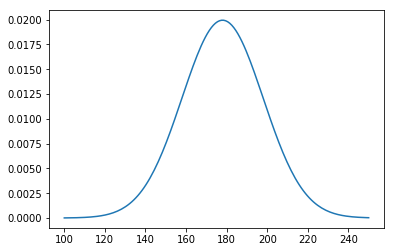

In [138]:
# 4.11
x = np.linspace(100, 250, num=150)
plt.plot(x, stats.norm.pdf(x, 178, 20));

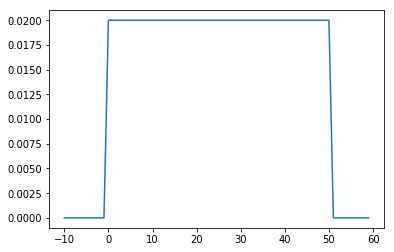

In [143]:
# 4.12
x = np.arange(-10, 60)
plt.plot(x, stats.uniform.pdf(x, 0, 50));

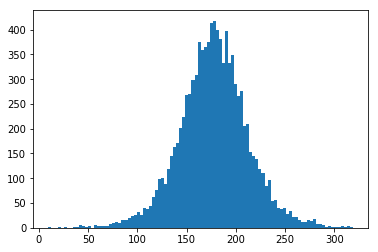

In [167]:
# 4.13
sample_mu = stats.norm.rvs(loc=178, scale=20, size=10000)
sample_sigma = stats.uniform.rvs(loc=0, scale=50, size=10000)
prior_h = stats.norm.rvs(loc=sample_mu, scale=sample_sigma)
plt.hist(prior_h, bins=100);

* ***this should be a 'vaguely bell-shaped curve with thick tails'. this does not fit what i see?***

* ***overthinking: model definition to bayes' theorem again:*** 
Pr(\mu, \sigma) = \prod_i Normal(h_i | \mu, \sigma) * Normal(\mu| 178, 20) * Uniform(\sigma, 0, 50) / {same term integrated over \mu and \sigma}.

so: for each datum, multiply likelihood with priors for mu and sigma, normaly through evidence to get posterior probablity for joined distribution over mu and sigma

### 4.3.3. Grid approximation of the posterior distribution

In [279]:
# 4.14 dataframe version

In [281]:
mu_list = np.linspace(start = 140, stop = 160, num = 200)
sigma_list = np.linspace(start = 4, stop = 9, num = 200)
mugrid, sigmagrid = np.meshgrid(mu_list, sigma_list)

post = pd.DataFrame(data={'mu':mugrid.ravel(), 'sigma': sigmagrid.ravel()})

post['LL'] = post.apply(
        func=lambda row: np.sum(stats.norm.logpdf(d2.height, loc = row.mu, scale = row.sigma)),
        axis=1
)


post['prod'] = post.LL + stats.norm.logpdf(post.mu, loc = 178, scale = 20) + stats.uniform.logpdf(post.sigma, loc = 0, scale = 50)

post['prob'] = np.exp(post['prod'] - post['prod'].max())

In [314]:
post.head()

,mu,sigma,LL,prod,prob
0,140.000000,4.0,-3812.775755,-3822.407448,0.0
1,140.100503,4.0,-3780.611884,-3790.234043,0.0
2,140.201005,4.0,-3748.670231,-3758.282879,0.0
3,140.301508,4.0,-3716.950793,-3726.553958,0.0
4,140.402010,4.0,-3685.453573,-3695.047278,0.0


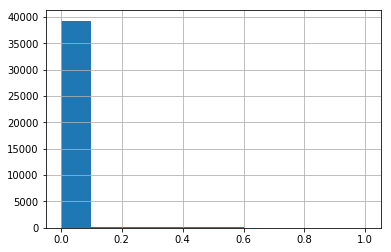

In [320]:
post['prob'].hist();

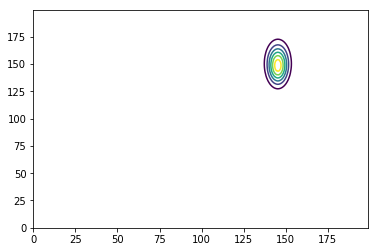

In [326]:
plt.contour(post['prob'].values.reshape((200, -1)));

In [226]:
import seaborn as sns

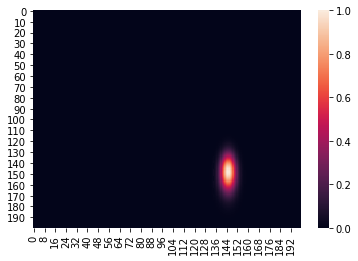

In [344]:
sns.heatmap(post['prob'].values.reshape((200, -1)));

side note, ***neat trick***: np.exp(post_prod) yields an array of 0s. np.exp(post_prod - post_prod.max()) yields non-zero numbers. those are not probabilities, but the are relative plausibilities, which is already super helpful

### 4.3.4. Sampling from the posterior

In [353]:
# 4.17
sample_rows = np.random.choice(np.arange(post.shape[0]), size=10000, replace=True, p=post['prob']/post['prob'].sum())
sample_mu = post['mu'].iloc[sample_rows]
sample_sigma = post['sigma'].iloc[sample_rows]

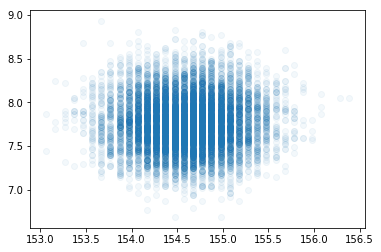

In [354]:
# 4.18
plt.scatter(sample_mu, sample_sigma, alpha=.05);

/anaconda3/envs/rethinking_statistics/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


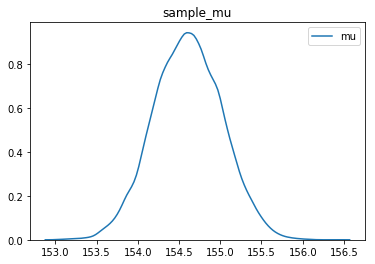

In [345]:
# 4.19
sns.kdeplot(sample_mu);
plt.title('sample_mu');

/anaconda3/envs/rethinking_statistics/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


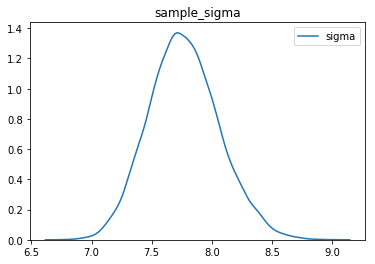

In [346]:
# 4.19
sns.kdeplot(sample_sigma);
plt.title('sample_sigma');

## for HDPI(data), i.e. code 4.20: look at PyMC3-translated examples to find right function

In [337]:
import pymc3 as pmc

In [341]:
# 4.20
print(pmc.hpd(sample_mu))
print(pmc.hpd(sample_sigma))

[153.66834171 155.27638191]
[7.24120603 8.3718593 ]


*** Overthinking: Sample size and the normality of σ’s posterior. ***

* gaussian approximation works well for mu, but not for sigma. intuition: variance can only be positive, so more uncertainty about how big it is as opposed to how small it is. effect: longer/thicker right tail
* following code illustrates this

In [348]:
# 4.21
d3 = d2.height.sample(n=20, random_state=42)

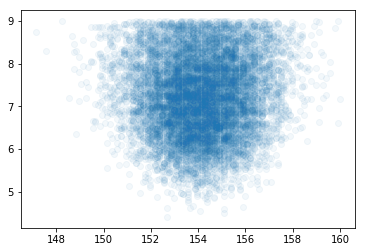

In [352]:
# 4.22
mu_list = np.linspace(start = 140, stop = 160, num = 200)
sigma_list = np.linspace(start = 4, stop = 9, num = 200)
mugrid, sigmagrid = np.meshgrid(mu_list, sigma_list)

post2 = pd.DataFrame(data={'mu':mugrid.ravel(), 'sigma': sigmagrid.ravel()})

post2['LL'] = post2.apply(
        func=lambda row: np.sum(stats.norm.logpdf(d3, loc = row.mu, scale = row.sigma)),
        axis=1
)


post2['prod'] = post2.LL + stats.norm.logpdf(post2.mu, loc = 178, scale = 20) + stats.uniform.logpdf(post2.sigma, loc = 0, scale = 50)

post2['prob'] = np.exp(post2['prod'] - post2['prod'].max())

sample2_rows = np.random.choice(np.arange(post2.shape[0]), size=10000, replace=True, p=post2['prob']/post2['prob'].sum())
sample2_mu = post2['mu'].iloc[sample2_rows]
sample2_sigma = post2['sigma'].iloc[sample2_rows]

plt.scatter(sample2_mu, sample2_sigma, alpha=.05);

/anaconda3/envs/rethinking_statistics/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


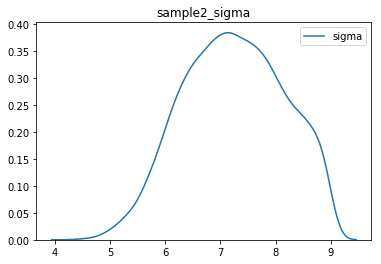

In [355]:
# 4.23
sns.kdeplot(sample2_sigma);
plt.title('sample2_sigma');

### 4.3.5. Fitting the model with map

* uses quadratic approximation "one of the great engines of applied statistics"
* fit's maximum a posteriori (map) estimate to find peak of posterior and curvature around it
* `map` function uses model definition to do hillclimbing on posterior
* however, note that following https://github.com/aloctavodia/Statistical-Rethinking-with-Python-and-PyMC3/blob/master/Chp_04.ipynb we will use mcmc instead

In [3]:
# 4.24
d = pd.read_csv('data/Howell1.csv', sep=';')
d2 = d[d.age >= 18]

In [5]:
d2.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


In [6]:
# 4.25

In [28]:
with pm.Model() as m4_1:
    mu = pm.Normal('mu', mu=178, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)

The authors of the PyMC3-translation of the book choose to [proceed with MCMC here](https://render.githubusercontent.com/view/ipynb?commit=311da5548a958574b9baf29646458871062284aa&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f616c6f637461766f6469612f537461746973746963616c2d52657468696e6b696e672d776974682d507974686f6e2d616e642d50794d43332f333131646135353438613935383537346239626166323936343634353838373130363232383461612f4368705f30342e6970796e62&nwo=aloctavodia%2FStatistical-Rethinking-with-Python-and-PyMC3&path=Chp_04.ipynb&repository_id=67766282&repository_type=Repository#Code-4.26) instead of doing a quadratic approximation like McElreath does. I'll try to stick closely to the original book instead.

I'll follow their MCMC approach anyway, so I don't have to wrestle with an unknown library to get quadratic approximations out, but it would be useful to actually learn about them more and also implement those

In [29]:
with m4_1:
    trace_4_1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:04<00:00, 859.08draws/s] 
/anaconda3/envs/rethinking_statistics/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


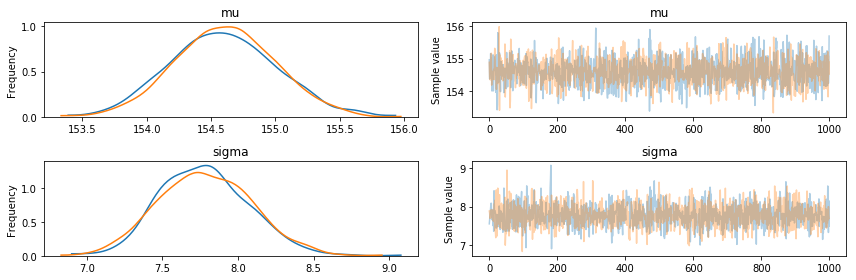

In [30]:
pm.traceplot(trace_4_1);

In [31]:
# Code 4.27
pm.summary(trace_4_1, alpha=.11).round(2)

/anaconda3/envs/rethinking_statistics/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
mu,154.60,0.4,0.01,153.98,155.25,2555.36,1.0
sigma,7.78,0.3,0.01,7.34,8.26,2127.51,1.0


* above is the fit model. numbers provide estimates of marginal distributions for parameters, meaning that the number reported for mu accounts for averaging over all plausibilities of sigma and vice versa.
* 89% as width for hpdi arbitrary width
* nearly the same output as for grid approx. this is to be expected when posterior is gaussian
* **overthinking: start values for quadratic approximation**: `rethinking` r package offers `map` routine for quadratic approximation. can be given explicit initialization values for hill climbing. default is to use samples from prio
* priors used were weak. how do things change for stronger prior? investigate by changing stddev for `mu` prior to 0.1 and inspect results

In [33]:
# Code 4.29
with pm.Model() as m4_2:
    mu = pm.Normal('mu', mu=178, sd=0.1)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace_4_2 = pm.sample(1000, tune=1000)

pm.summary(trace_4_2, alpha=.11).round(2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1176.46draws/s]
/anaconda3/envs/rethinking_statistics/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
mu,177.86,0.10,0.00,177.69,178.00,1760.05,1.0
sigma,24.56,0.92,0.02,23.13,26.01,1815.65,1.0


* observations: value for `mu` nearly unaffected by data, remains at prior position. effect of strong prior. however, unexpected: posterior distribution of `sigma` also very different, even though only `mu` prior changed. explanation: marginal distrbution of `sigma` needs to change to accommodate changed distribution of `mu`. once model assumes that this is different the rest needs to be made to fit
* **overthinking: how strong is a prior?** if seeing prior as posterior of earlier inference: in this model easy to determine how much data would have been needed to be observed to create prior. sigma_post = 1/sqrt(n). thus n = 1/sigma_post^2. for sigma_post = 0.1 we compute n = 178. so would have needed to observe 178 data points with mean of 178 to create the previous prior. for weaker prior with stddev 20 would have only needed to observe 0.0025 data points, much weaker. also note that sigma_post = 1/sqrt(n) is same formula as for standard error of sampling distribution of the mean in non-bayesian inference. not by accident

### 4.3.6. sampling from a map fit
* get samples from quadratic approx by recognizing that this approximation is just a multidimensional gaussian. one dimension per parameter (2 total, 1 for mu, 1 for sigma in this case). covariance matrix between parameters created during model fitting.
* **note: pymc3 translation of code still has mcmc data instead of quadratic approx. this is also what i am using by virtue of employing their code**

In [39]:
import numpy as np

In [42]:
# Code 4.30
trace_df = pm.trace_to_dataframe(trace_4_1)
trace_df.cov()

,mu,sigma
mu,0.161902,0.000833
sigma,0.000833,0.087093


* this is a variance-covariance matrix. diagnoal: variance of parameters. other elements: correlations of parameter pairs. decomposed:

In [43]:
# Code 4.31
np.diag(trace_df.cov())

array([0.16190161, 0.08709303])

In [44]:
trace_df.corr()

,mu,sigma
mu,1.000000,0.007016
sigma,0.007016,1.000000


* correlation between mu and sigma close to 0. learning something about one tells us little about the other. typical for simple gaussian models, quite rare in more complex cases
* for 'how to get samples in Code 4.32': already have samples due to using mcmc, can just use those

In [45]:
# Code 4.32
trace_df.head()

,mu,sigma
0,154.962738,7.550430
1,154.372879,7.651577
2,154.524861,7.728631
3,154.541939,7.827398
4,155.153394,7.936040


In [46]:
# Code 4.33
pm.summary(trace_4_1, alpha=.11).round(2)

/anaconda3/envs/rethinking_statistics/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
mu,154.60,0.4,0.01,153.98,155.25,2555.36,1.0
sigma,7.78,0.3,0.01,7.34,8.26,2127.51,1.0


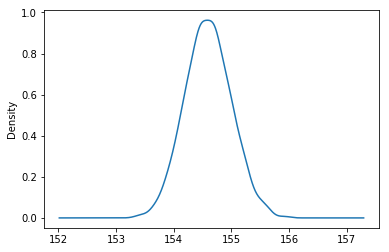

In [52]:
trace_df['mu'].plot.density();

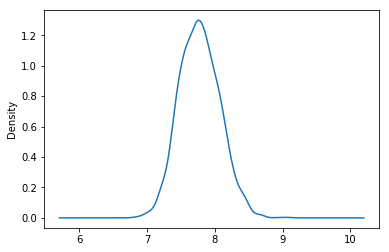

In [53]:
trace_df['sigma'].plot.density();

* **overthinking: under the hood with multivariate sampling** posterior samples of quadratix approximation taken from multivariate normal distribution. like this:

In [57]:
# Code 4.34
stats.multivariate_normal.rvs(mean=trace_df.mean(), cov=trace_df.cov(), size=10)

array([[154.573164  ,   7.32839202],
       [154.45030795,   8.37125676],
       [155.04624746,   7.74737568],
       [153.97422913,   7.71796723],
       [154.36542258,   7.79901329],
       [154.37474763,   7.72417743],
       [154.64092657,   8.13386869],
       [154.19441888,   7.96907941],
       [155.09660359,   7.83126281],
       [154.72149806,   7.2383024 ]])

* **overthinking: getting sigma right** quadratic assumption for sigma can be problematic. can help to estimate log(sigma) instead. why is this helpful? distribution of log(sigma) much more often gaussian than distribution of sigma. done in the following code:
* (note that pymc3 translation diverges again. in book: model through normal, exponentiate log_sigma, and give prior to log_sigma. in pymc3: use lognormal instead)

In [58]:
# Code 4.35 and Code 4.36
with pm.Model() as m4_1_logsigma:
    mu = pm.Normal('mu', mu=178, sd=20)
    sigma = pm.Lognormal('sigma', mu=2, tau=0.01)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace_4_1_logsigma = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:04<00:00, 861.02draws/s] 
/anaconda3/envs/rethinking_statistics/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


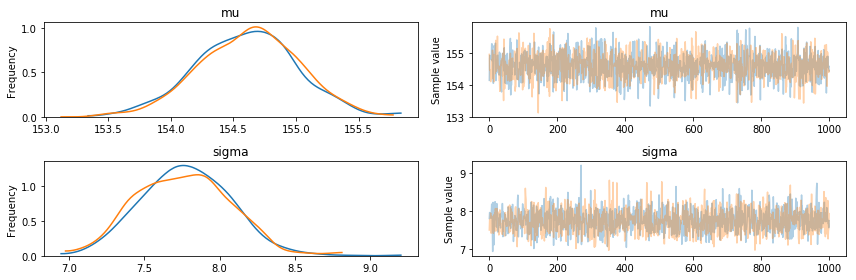

In [59]:
pm.traceplot(trace_4_1_logsigma);

## 4.4. Adding a predictor